# libraries

In [19]:
import re
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
from datasets import ClassLabel, Sequence
import random
from IPython.display import display, HTML
from tqdm import tqdm
from fastbm25 import fastbm25

In [20]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [21]:
def evaluate_type_BM25(T, k):
    if T:
        K = k
        MODEL_PATH = 'model/QA_modelBM25_k_'+str(K)
    else:
        K = k
        MODEL_PATH = 'model/QA_model_TFIDF_k_'+str(K)
    print(MODEL_PATH)
    device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    return MODEL_PATH, K, device

MODEL_PATH, K, device = evaluate_type_BM25(True, 4)    

model/QA_modelBM25_k_4
cuda:1


# load data

In [22]:
TRAIN_PATH = 'data/train.txt'
DEV_PATH = 'data/val.txt'
TEST_PATH = 'data/test.txt'
TEST_ANSWER_PATH = 'data/Assignment2_test_answer.txt'

In [23]:
def read_data_from_txt(path):
    QandA = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in tqdm(file):
            #print(line)
            if line != "\n":
                splitted = line.split("|||")
                sentences = splitted[0]
                question  = r" ".join(splitted[1].split())
                answer    = re.sub("\n","",splitted[2])
                answer = r" ".join(answer.split())
                QandA.append((sentences, question, answer))
    return QandA

def read_answer_data(path):
    QandA = []
    with open(path, 'r', encoding='utf-8') as file:
        for line in tqdm(file):
            #print(line)
            if line != "\n":
                splitted = line.split("|||")
                question = r" ".join(splitted[0].split())
                answer  = re.sub("\n","",splitted[-1])
                answer = r" ".join(answer.split())
                QandA.append((question, answer))
    return QandA

def correct_test_answer(data, answer):
    QandA = []
    for origin, correct in zip(data, answer):
        sentence = origin[0]
        question = origin[1]
        answer   = correct[1]
        QandA.append((sentence, question, answer))
    return  QandA   

In [24]:
train_data  = read_data_from_txt(TRAIN_PATH)
del train_data[51641] #51641報錯
valid_data  = read_data_from_txt(DEV_PATH)
# test_data
test_data   = read_data_from_txt(TEST_PATH)
test_answer = read_answer_data(TEST_ANSWER_PATH)
test_data   = correct_test_answer(test_data, test_answer)

99820it [00:01, 64737.45it/s]
13893it [00:00, 67530.58it/s]
27248it [00:00, 73603.52it/s]
27248it [00:00, 231682.90it/s]


In [25]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

99819
13893
27248


average:  17.27763505578391


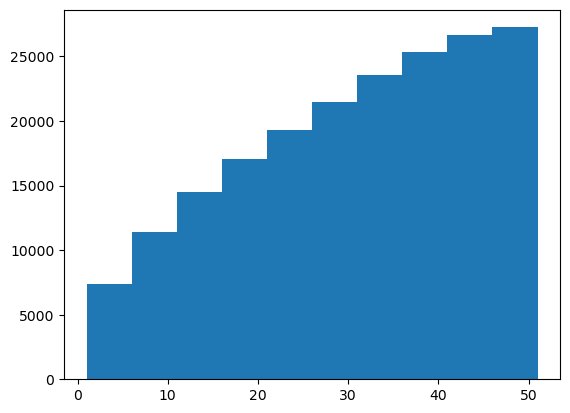

In [29]:
Result=[]
total = 0
for i in range(len(test_data)):
    muti_answer_count = 0
    sentences = re.findall(r'<s>(.*?)</s>', test_data[i][0])
    for sen in sentences:
        if test_data[i][2] in sen:
            muti_answer_count = muti_answer_count+1
    Result.append(muti_answer_count)
    total = total+muti_answer_count
print('average: ', total/len(Result))
# 文本中，含有答案超過XX次以上的list    
import matplotlib.pyplot as plt
plt.hist(Result, bins=10, label= [0,5,10,15,20,25,30,35,40,45,50,60,70], cumulative =True)
plt.show()              

In [27]:
def check_answer(data):
    index = []
    for sentences, question, answer in tqdm(data):
        ans = "FALSE"
        sentences = re.findall(r'<s>(.*?)</s>', sentences)
        for sentence in sentences:
            try:
                if answer in sentence:
                    ans = "TRUE" 
            except:
                continue
        if ans == "FALSE":
                index.append(i)
    if len(index) == 0:
        print("Every answer is in context.")
check_answer(train_data)
check_answer(valid_data)

100%|███████████████████████████████████| 99819/99819 [00:16<00:00, 6214.60it/s]


Every answer is in context.


100%|███████████████████████████████████| 13893/13893 [00:02<00:00, 6200.12it/s]

Every answer is in context.


# 用tf-idf 選取和問題最相近的句子，包含答案

In [9]:
'''
def get_top_k_articles(query, docs, k=1):

    # Initialize a vectorizer that removes English stop words
    vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')

    # Create a corpus of query and documents and convert to TFIDF vectors
    query_and_docs = [query] + docs
    matrix = vectorizer.fit_transform(query_and_docs)

    # Holds our cosine similarity scores
    scores = []

    # The first vector is our query text, so compute the similarity of our query against all document vectors
    for i in range(1, len(query_and_docs)):
        scores.append(cosine_similarity(matrix[0], matrix[i])[0][0])

    # Sort list of scores and return the top k highest scoring documents
    sorted_list = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)
    top_doc_indices = [x[0] for x in sorted_list[:k]]
    top_docs = [docs[x] for x in top_doc_indices]
  
    return top_docs

def get_topk_tfidf_sentence(data):
    contexts = []
    for sentences, question, answer in tqdm(data):
        contained_answer_sentence = []
        sentences = re.findall(r'<s>(.*?)</s>', sentences)
        for sentence in sentences:
            if answer in sentence:
                contained_answer_sentence.append(sentence)
        doc = get_top_k_articles(question, contained_answer_sentence)
        context = ". ".join(doc)
        contexts.append(context)
    return contexts
train_contexts = get_topk_tfidf_sentence(train_data)
valid_contexts =   get_topk_tfidf_sentence(valid_data)
test_contexts  = get_topk_tfidf_sentence(test_data)
'''

'\ndef get_top_k_articles(query, docs, k=1):\n\n    # Initialize a vectorizer that removes English stop words\n    vectorizer = TfidfVectorizer(analyzer="word", stop_words=\'english\')\n\n    # Create a corpus of query and documents and convert to TFIDF vectors\n    query_and_docs = [query] + docs\n    matrix = vectorizer.fit_transform(query_and_docs)\n\n    # Holds our cosine similarity scores\n    scores = []\n\n    # The first vector is our query text, so compute the similarity of our query against all document vectors\n    for i in range(1, len(query_and_docs)):\n        scores.append(cosine_similarity(matrix[0], matrix[i])[0][0])\n\n    # Sort list of scores and return the top k highest scoring documents\n    sorted_list = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)\n    top_doc_indices = [x[0] for x in sorted_list[:k]]\n    top_docs = [docs[x] for x in top_doc_indices]\n  \n    return top_docs\n\ndef get_topk_tfidf_sentence(data):\n    contexts = []\n    for sente

In [10]:
def get_topk_bm25_sentence(data, k):
    contexts = []
    for sentences, question, answer in tqdm(data):
        contained_answer_sentence = []
        sentences = re.findall(r'<s>(.*?)</s>', sentences)
        for sentence in sentences:
            if answer in sentence:
                contained_answer_sentence.append(sentence)
        tokenized_corpus = [doc.lower().split(" ") for doc in contained_answer_sentence]
        FASTBM25 = fastbm25(tokenized_corpus)
        tokenized_answer = question.lower().split(" ")
        doc = FASTBM25.top_k_sentence(tokenized_answer, k=k)
        final_doc = []
        for list_doc, _,score in doc:
            final_doc.append(" ".join(list_doc))
        context = ". ".join(final_doc)
        contexts.append(context)
    return contexts

train_contexts = get_topk_bm25_sentence(train_data, K)
valid_contexts = get_topk_bm25_sentence(valid_data, K)
test_contexts  = get_topk_bm25_sentence(test_data,  K)

100%|████████████████████████████████████| 27248/27248 [00:31<00:00, 862.47it/s]


# 轉換成Dataframe

In [11]:
def convert_to_dataframe(data, contexts):
    ques = []
    ans= []
    for sentences, question, answer in data:
        ques.append(question)
        ans.append(answer)
    return pd.DataFrame({'sentences':contexts,'question':ques,'answer':ans})
train_data = convert_to_dataframe(train_data, train_contexts)
valid_data = convert_to_dataframe(valid_data, valid_contexts)
test_data =  convert_to_dataframe(test_data, test_contexts)

In [12]:
def show_random_elements(dataset, num_examples=1):
    df = dataset.sample(n = num_examples)
    display(HTML(df.to_html()))
    
show_random_elements(train_data)

In [13]:
def clean_answer_not_in_context(data):
    index_ids=[]
    for i in range(len(data)):
        if data['answer'].iloc[i] in data['sentences'].iloc[i]:
            continue
        else:
            index_ids.append(i)
    data = data.drop(index_ids, axis=0)
    print(len(data))
    return data

train_data = clean_answer_not_in_context(train_data)
valid_data = clean_answer_not_in_context(valid_data)
test_data  = clean_answer_not_in_context(test_data)

99741
13885
27217


# tokenized data

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [15]:
def get_tokennize_list(data):
    data_question = data['question'].tolist()
    data_context = data['sentences'].tolist()
    return data_question, data_context

In [16]:
train_question, train_context = get_tokennize_list(train_data)
valid_question, valid_context = get_tokennize_list(valid_data)
test_question,  test_context  = get_tokennize_list(test_data)

In [17]:
train_encodings = tokenizer(train_question, train_context, truncation=True, padding=True)
val_encodings   = tokenizer(valid_question, valid_context, truncation=True, padding=True)
test_encodings  = tokenizer(test_question, test_context, truncation=True, padding=True)

In [18]:
tokenizer.decode(train_encodings['input_ids'][0])

"[CLS] last 8 years life, galileo house arrest espousing man's theory [SEP] lebowski sweater replica jun 17, 2013 history last 8 years life, galileo house arrest espousing man's theory copernicus espn's top 10 time. images knickerless women jun 17, 2013 history last 8 years life, galileo house arrest espousing man's theory copernicus espn's top 10 time. christa mcauliffe autopsy jun 17, 2013 history last 8 years life, galileo house arrest espousing man's theory copernicus espn's top 10 time. mary nightingale botox jun 17, 2013 history last 8 years life, galileo house arrest espousing man's theory copernicus espn's top 10 time [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

# 找答案的start end index

In [19]:
def get_Start_End_index(data):
    data['start'] = [y.index(x) for x,y in zip(data["answer"],data["sentences"])]
    data['end']   = [x+len(str(y)) for x,y in zip(data["start"],data["answer"])]
get_Start_End_index(train_data)
get_Start_End_index(valid_data)
get_Start_End_index(test_data)

In [20]:
train_data.head()

sentences  \
0   lebowski sweater replica jun 17 , 2013 histor...   
1   jim thorpe bio , stats , results olympics spo...   
2   yuma arizona oddities part 3 jul 21 , 2011 yu...   
3   gravestone famous ancestor roger sherman sign...   
4   full text catalog educational films internet ...   

                                            question      answer  start  end  
0  last 8 years life , galileo house arrest espou...  copernicus    113  123  
1  2 1912 olympian football star carlisle indian ...  jim thorpe      1   11  
2  city yuma state record average 4 , 055 hours s...     arizona      6   13  
3  signer dec indep , framer constitution mass , ...  john adams    176  186  
4  title aesop fable , insect shared billing gras...         ant    251  254

In [21]:
train_data['sentences'].iloc[0][113:123]

'copernicus'

# add token positions

In [22]:
train_answer = train_data[['start', 'end']].to_dict('records')
valid_answer = valid_data[['start', 'end']].to_dict('records')
test_answer  = test_data[['start', 'end']].to_dict('records')

In [23]:
i = 0
print(train_data['answer'].iloc[i])
a = train_encodings.char_to_token(i, train_answer[i]['start'], 1)
print(a)
b = train_encodings.char_to_token(i, train_answer[i]['end']-1, 1)
print(b)
print(tokenizer.decode(train_encodings['input_ids'][i][47:b+1]))

copernicus
47
49
copernicus


In [24]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['start'],1))
        end_positions.append(encodings.char_to_token(i, answers[i]['end']-1,1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
            
        shift = 1
        while end_positions[-1] is None:
            if answers[i]['end'] - shift>=0:
                end_positions[-1] = encodings.char_to_token(i, answers[i]['end'] - shift, 1)
                shift += 1 
            else:
                break
            
    encodings.update({'start': start_positions, 'end': end_positions})

add_token_positions(train_encodings, train_answer)
add_token_positions(val_encodings, valid_answer)
add_token_positions(test_encodings, test_answer)

In [25]:
# Convert char_based_id to token_based_id
# Find the corossponding token id after input being tokenized
add_token_positions(train_encodings, train_answer)
add_token_positions(val_encodings, valid_answer)
add_token_positions(test_encodings, test_answer)

In [26]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start', 'end'])

In [27]:
print(train_encodings['start'][0])
print(train_encodings['end'][0])
print(val_encodings['start'][0])
print(val_encodings['end'][0])

47
49
36
38


In [28]:
i=23
print(train_data['sentences'].iloc[i][train_answer[i]['start']:train_answer[i]['end']])
print(tokenizer.decode(train_encodings['input_ids'][i][train_encodings['start'][i]:train_encodings['end'][i]+1]))

oratory
oratory


# convert to dataset

In [29]:
class QADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        try:
            return {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        except:
            print(idx)
            
    def __len__(self):
        return len(self.encodings.input_ids)

In [30]:
train_dataset = QADataset(train_encodings)
val_dataset   = QADataset(val_encodings)
test_dataset  = QADataset(test_encodings)

In [31]:
next(iter(val_dataset))

{'input_ids': tensor([  101, 22620,  1394,  3003,   117,  1724,  4249,  2247,   117,  1642,
          6048, 12200, 22217,  1116,   102,  1714,  6746, 18464,  5752,  2025,
          8419,  2158, 22620,  1394,  3003,   117,  1724,  4249,  2247,   117,
          1642,  6048, 12200, 22217,  1116,   117, 23123,  1158,  2787,  6394,
           119,  1185,  2707, 10615,  1489,   117,  1369,  1270,  7761,  1821,
         26237,  1389,  5752, 22620,  1394,  3003,   117,  1724,  4249,  2247,
           117,  1642,  6048, 12200, 22217,  1116, 23123,  1158,  2787,  6394,
           119,  1299,  1186,  1299,  1186,  6048,  3377, 22620,  1394,  1821,
         26237,  1161, 23123,  1158,  2787,  5016, 23123,  1158,  2787,   117,
           175, 18318, 25300,  1202,  5031, 14846,  8037,  7959,  5075,   117,
          3494,  2766,  2286,  3003,  1346,  2761,   117,  4249,  2247,  1338,
         12890, 19587,  1676, 12477,  1616,   117,  1724,  1893,  1603,  1642,
           117,  1141,  9616, 12200, 22

# Model

In [32]:
from transformers import BertModel

class QAModel(torch.nn.Module):

    def __init__(self):

        super(QAModel, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.fc = torch.nn.Linear(768, 2)
        

    def forward(self, input_ids, attention_mask, token_type_ids):

        output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)
        logits = output[0]
        out = self.fc(logits)

        return out

In [33]:
from transformers import AdamW
# Put model on device
model = QAModel().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# training

In [34]:
# Pack data into dataloader by batch
batch_size   = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [35]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

12468
1736
3403


In [36]:
training_epoch = 3
loss_fct = CrossEntropyLoss()

In [37]:
def evaluate(valid_loader):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        loop = tqdm(valid_loader, leave=True)
        for batch_id, batch in enumerate(loop):
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start          = batch['start'].to(device)
            end            = batch['end'].to(device)

            # model output
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

            start_logits, end_logits = torch.split(outputs, 1, 2)

            start_logits = start_logits.squeeze(-1).contiguous()
            end_logits   = end_logits.squeeze(-1).contiguous()

            start_loss = loss_fct(start_logits, start)
            end_loss   = loss_fct(end_logits, end)

            loss = start_loss + end_loss
            running_loss += loss.item()
            
        print('Validation Loss {:.4f}'.format(running_loss / len(valid_loader)))

In [ ]:
for epoch in range(training_epoch):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, leave=True)
    for batch_id, batch in enumerate(loop):
        # reset
        optim.zero_grad()

        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start          = batch['start'].to(device)
        end            = batch['end'].to(device)

        # model output
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        start_logits, end_logits = torch.split(outputs, 1, 2)

        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits   = end_logits.squeeze(-1).contiguous()

        start_loss = loss_fct(start_logits, start)
        end_loss = loss_fct(end_logits, end)
        loss = start_loss + end_loss
        # calculate loss
        loss.backward()
        # update parameters
        optim.step()
        running_loss += loss.item()
        
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    print('Training Loss {:.4f}'.format(running_loss / len(train_loader)))
    evaluate(valid_loader)
    
torch.save(model.state_dict(), MODEL_PATH)

Epoch 0: 100%|██████████████| 12468/12468 [2:12:14<00:00,  1.57it/s, loss=0.764]


Training Loss 1.8243


100%|███████████████████████████████████████| 1736/1736 [05:18<00:00,  5.45it/s]


Validation Loss 1.3535


Epoch 1: 100%|███████████████| 12468/12468 [2:12:12<00:00,  1.57it/s, loss=12.5]


Training Loss 3.9557


100%|███████████████████████████████████████| 1736/1736 [05:13<00:00,  5.54it/s]


Validation Loss 12.2006


Epoch 2:   2%|▎                | 258/12468 [02:44<2:07:40,  1.59it/s, loss=12.5]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 2:  41%|██████▌         | 5079/12468 [53:37<1:17:18,  1.59it/s, loss=12.5]

In [40]:
print(123)

123


In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
def predict(test_loader):
    
    model.eval()
    
    predict_pos = []
    sub_output = []

    loop = tqdm(test_loader, leave=True)
    for batch_id, batch in enumerate(loop):
        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)

        # model output
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        start_logits, end_logits = torch.split(outputs, 1, 2)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits   = end_logits.squeeze(-1).contiguous()

        start_prdict = torch.argmax(start_logits, 1).cpu().numpy()
        end_prdict   = torch.argmax(end_logits, 1).cpu().numpy()

        for i in range(len(input_ids)):
            predict_pos.append((start_prdict[i].item(), end_prdict[i].item()))
            sub = tokenizer.decode(input_ids[i][start_prdict[i]:end_prdict[i]+1])
            sub_output.append(sub)
    
    return sub_output, predict_pos

In [ ]:
sub_output, predict_pos = predict(test_loader)

In [ ]:
sub_output[0]

In [ ]:
def nltk_token_string(sentence):
    # print(sentence)
    tokens = nltk.word_tokenize(sentence)
    for i in range(len(tokens)):
        if len(tokens[i]) == 1:
            tokens[i] = re.sub(r"[!\"#$%&\'()*\+, -.\/:;<=>?@\[\\\]^_`{|}~]", '', tokens[i])
    while '' in tokens:
        tokens.remove('')
    tokens = ' '.join(tokens)
    return tokens

In [ ]:
def get_output_post_fn(test, sub_output):
    sub = []
    for i in range(len(test)):

        sub_pred = sub_output[i].split()

        temp = sub_pred.copy()
        if sub_pred is None:
            sub_pred = []
        else:
            for j in range(len(temp)):
                if temp[j] == '[SEP]':
                    sub_pred.remove('[SEP]')
                if temp[j] == '[PAD]':
                    sub_pred.remove('[PAD]')

        sub.append(' '.join(sub_pred))
        
    return sub

In [ ]:
sub = get_output_post_fn(test_data, sub_output)
test_data['predict'] = sub
test_data.head(20)

In [ ]:
def lcs(X, Y):
    X_, Y_ = [], []
    
    X_ = nltk_token_string(X)
    Y_ = nltk_token_string(Y)

    m = len(X_)
    n = len(Y_)
 
    # declaring the array for storing the dp values
    L = [[None]*(n + 1) for i in range(m + 1)]
 
    """Following steps build L[m + 1][n + 1] in bottom up fashion
    Note: L[i][j] contains length of LCS of X[0..i-1]
    and Y[0..j-1]"""
    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0 or j == 0 :
                L[i][j] = 0
            elif X_[i-1] == Y_[j-1]:
                L[i][j] = L[i-1][j-1]+1
            else:
                L[i][j] = max(L[i-1][j], L[i][j-1])
 
    # L[m][n] contains the length of LCS of X[0..n-1] & Y[0..m-1]
    return L[m][n]


def acc(full, sub):
    common = lcs(full, sub)
    union = len(full) + len(sub) - common
    accuracy = float(common/union)

    return accuracy

In [ ]:
import nltk
nltk.download('punkt')
acc_sum = 0
for i in range(valid_data.shape[0]):
    accuracy = acc(valid_data.iloc[i]["answer"], valid_data.iloc[i]['predict'])
    acc_sum += accuracy

print("lcs accuracy: ", acc_sum/valid_data.shape[0])

In [ ]:
import re
import collections
import string
  
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
  
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
  
    def white_space_fix(text):
        return " ".join(text.split())
  
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
  
    def lower(text):
        return text.lower()
  
    return white_space_fix(remove_articles(remove_punc(lower(s))))
    
def get_tokens(s):
    if not s:
        return []
    return normalize_answer(s).split()
   
def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))
  
def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def f1_metric(data):
    f1_score = 0.0
    for answer, pred in zip(data["answer"], data['predict']):
        f1_score+=compute_f1(answer, pred)
    print("f1 score: {}".format(f1_score/len(data)))
f1_metric(valid_data)

In [ ]:
test_sub_output, test_predict_pos = predict(test_loader)

In [ ]:
test_sub = get_output_post_fn(test_data, test_sub_output)
test_data['predict'] = test_sub
test_data.tail(20)

In [ ]:
len(test_sub)

In [ ]:
test_submit_data  = read_data_from_txt(TEST_PATH)

In [ ]:
test_submit_data[0][1]

In [ ]:
text = []
question = []
for i,j,k in test_submit_data:
    text.append(i)
    question.append(j)
print(len(text))
print(len(question))

In [ ]:
'''
path = 'data/final-submit.txt'
f = open(path, 'w')
for question, answer in zip(question, test_sub):
    f.write(question+"|||"+answer+"\n")
f.close()
'''